# Predicting the class and groups of songs

## 1. Exploratory data analysis

In [2]:
# Import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split ##

from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.spatial.distance import hamming

In [88]:
# Load music data
music = pd.read_csv('Music.csv')
music.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [5]:
# Check how large the data set is
music.shape

(114000, 21)

In [6]:
# Check the names of the columns
music.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')

In [17]:
# Check how many nulls there are in the data set
def null_vals(dataframe):
    null_vals = dataframe.isnull().sum()
    total_cnt = len(dataframe)
    null_vals = pd.DataFrame(null_vals,columns=['null count'])
    null_vals['percentage of nulls'] = round((null_vals['null count']/total_cnt)*100,3)
    return null_vals.sort_values('percentage of nulls', ascending=False)

In [18]:
null_vals(music)

,null count,percentage of nulls
artists,1,0.001
album_name,1,0.001
track_name,1,0.001
Unnamed: 0,0,0.000
mode,0,0.000
time_signature,0,0.000
tempo,0,0.000
valence,0,0.000
liveness,0,0.000
instrumentalness,0,0.000


In [20]:
music[(music.artists.isnull()) & (music.album_name.isnull()) & (music.track_name.isnull())]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,-9.46,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop


In [7]:
# Check the data types for each column
music.dtypes

Unnamed: 0            int64
track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

As per above, the only nulls in the data are from one entry where there are null values for 'artists', 'album_name' and 'track_name'.
These are categorical columns (alongside 'track_id') that will not be used in the models to predict the target classes.

'Unnamed: 0' will also be dropped as a feature since it is merely a repeat of the row index.

In [89]:
# Show summary statistics
music.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [11]:
music['popularity'].value_counts()

0      16020
22      2354
21      2344
44      2288
1       2140
       ...  
96         7
94         7
95         5
100        2
99         1
Name: popularity, Length: 101, dtype: int64

In [12]:
music[music.popularity == 100]

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
20001,20001,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,dance
81051,81051,3nqQXoyQOWXiESFLlDF1hG,Sam Smith;Kim Petras,Unholy (feat. Kim Petras),Unholy (feat. Kim Petras),100,156943,False,0.714,0.472,...,-7.375,1,0.0864,0.013,0.000005,0.266,0.238,131.121,4,pop


Unholy is a very popular song, so we can deduce that a score of 100 relates to a very popular song and a score of 0 relates to a very unpopular song.
Unholy also has two different entries - that's because it has been assigned two different genres, one for each entry.

In [13]:
# 'track_genre' is a categorical column that could be chosen as the target if we framed this 
# as a supervised classification problem
# There are over 100 different classes of genre though... 
# so these would have to be binned into smaller groups to make life easier
music['track_genre'].value_counts()

acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: track_genre, Length: 114, dtype: int64

In [22]:
# Like Unholy, here is another track that has been classified as different genres, 
# this time 9 different times which is a lot!
music[music['track_id'] == '6S3JlDAGk3uu3NtZbPnuhS']

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
8315,8315,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,blues
19759,19759,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,country
34728,34728,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,folk
62226,62226,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-pop
63087,63087,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,j-rock
82064,82064,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,power-pop
84129,84129,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,psych-rock
99727,99727,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,singer-songwriter
102732,102732,6S3JlDAGk3uu3NtZbPnuhS,Badfinger,Straight Up (Remastered 2010 / Deluxe Edition),Baby Blue - Remastered 2010,67,217346,False,0.623,0.876,...,-7.788,1,0.066,0.0189,0.0134,0.0728,0.515,124.431,4,songwriter


In [91]:
# Count the number of different assigned genres per track - 
# the above example actually has the most genres out of all the tracks in the data
music.groupby('track_id')[['track_genre']].count().sort_values('track_genre', ascending=False)

,track_genre
track_id,
6S3JlDAGk3uu3NtZbPnuhS,9
2kkvB3RNRzwjFdGhaUA0tz,8
2Ey6v4Sekh3Z0RUSISRosD,8
4GPQDyw9hC1DiZVh0ouDVL,7
61202Zzk9rk4bPMZLh2gr6,7
...,...
2rHfLANXNn5ppnW0jqv8h2,1
2rHX2oJ6sy9knGTBge4A3E,1
2rHJDOPLTw7w5NqrTg3iBb,1


### <u>Explaining my choice of target:</u>

If we wanted to create new columns for each type of genre that a track could be classified as, we'd have to add 8 more columns to the data set...
... adding more variables could be problematic as it could create more noise and therefore increase the likelihood of the chosen model over-fitting.

Furthermore, if we wanted to group the different genres into bins we run into another issue of knowing how to determine which genre fits into which bin.
The genres already defined in the data may already be subject to bias. For instance:
- 'world-music' could entail folk, rock, house etc... therefore the data may not account for the nuances of music within different cultures outside the USA or UK.
- Tackling the above would require even more time to research and rectify (such as sampling individual tracks and learning about different cultures) than is available.
- Genres like 'singer-songwriter' don't really say much about the musical style of a track, and there is a history of this label being used by artists associated with of certain genres, genders and images

We want to avoid adding more bias to the model therefore 'track_genre' should not be selected as the target.

Instead, let's go for a more simple option which is 'danceability':
Values range from 0 to 1 and can be binned into different groups (e.g. Low, Medium, High)

In [92]:
# Create a copy of the original data set to make the changes mentioned previously
music_copy = music.copy()
music_copy.drop(columns=['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'track_genre'], inplace=True)
music_copy.drop_duplicates(inplace=True)
music_copy.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


In [93]:
music_copy.shape

(86706, 15)

In [94]:
# Group 'danceability' values into bins
bins = [0.000, 0.333, 0.666, 0.999] ## bin ranges to bucket the zip codes
labels = ['Low', 'Medium', 'High'] ## bin labels
music_copy['danceability'] = pd.cut(x=music_copy['danceability'], bins=bins, labels=labels, include_lowest=True)

music_copy.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,High,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,Medium,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,Medium,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,False,Low,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,False,Medium,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


In [95]:
music_copy.dtypes

popularity             int64
duration_ms            int64
explicit                bool
danceability        category
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature         int64
dtype: object

In [96]:
# Encode the 'danceability' column
music_copy['danceability'] = music_copy['danceability'].map({'Low':1, 'Medium':2, 'High':3})
music_copy['danceability'] = music_copy['danceability'].astype(int)
music_copy.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,73,230666,False,3,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4
1,55,149610,False,2,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4
2,57,210826,False,2,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4
3,71,201933,False,1,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3
4,82,198853,False,2,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4


In [98]:
music_copy.dtypes

popularity            int64
duration_ms           int64
explicit               bool
danceability          int32
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

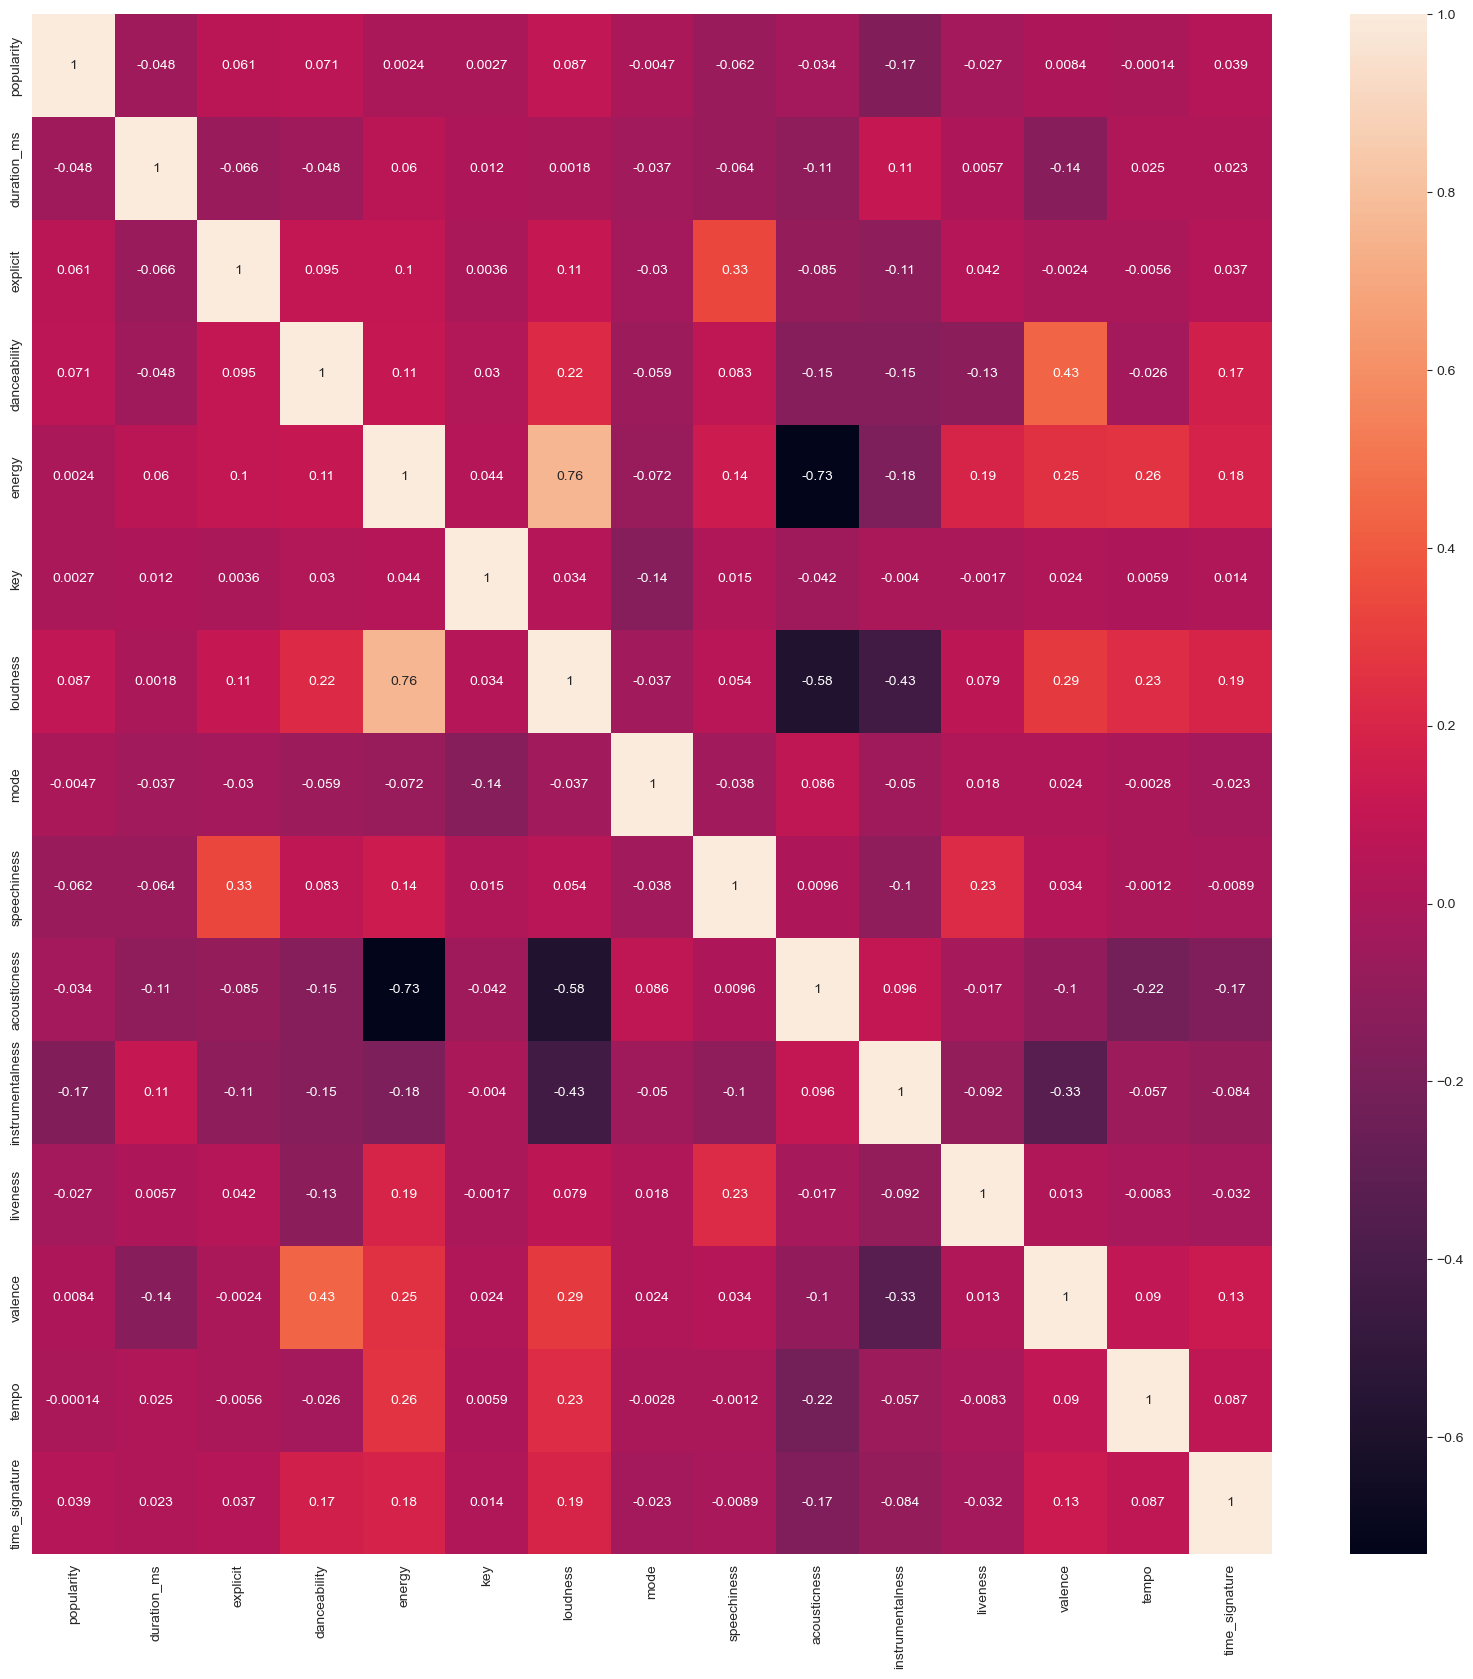

In [100]:
# Explore the correlation between the features and the target
plt.figure(figsize=(20,20))
sns.heatmap(music_copy.corr(), annot=True, cmap='rocket')
plt.show()

Select the following columns as features based on their correlation with the target column, 'danceability':
- 'energy' (0.11)
- 'loudness' (0.22)
- 'valence' (0.43)
- 'time_signature' (0.17)

Note that these correlations aren't particularly high.

Also, variables like 'loudness' and 'time_signature' seem immediately more objective than 'energy' or 'valence'.
Based on brief research I conducted:
- 'valence' describes the musical positiveness conveyed by a track
- 'energy' represents a perceptual measure of intensity and activity

There perhaps might be an element of bias involved when defining or calculating these variables... however it's hard to say without going truly in-depth to discover how exactly these numbers were calculated.

## 2. KNN modelling

Try with 4 features

In [162]:
# Define features and target
X = music_copy[['energy', 'loudness', 'valence', 'time_signature']]
y = music_copy.danceability

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

In [111]:
X_train[0:5]

,energy,loudness,valence,time_signature
14325,0.1540,-10.183,0.4950,4
2779,0.9310,-6.348,0.2950,4
4411,0.0358,-28.579,0.0396,3
79450,0.0347,-20.034,0.2320,4
38580,0.7070,-6.520,0.2570,3


In [112]:
X_test[0:5]

,energy,loudness,valence,time_signature
21143,0.904,-4.091,0.8230,5
90433,0.363,-12.517,0.5560,4
42835,0.657,-9.335,0.0655,4
7613,0.485,-13.665,0.5360,4
25692,0.963,-4.044,0.8020,4


In [149]:
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [150]:
# View scaled data
X_train[0:5]

array([[0.154     , 0.75516745, 0.49748744, 0.8       ],
       [0.931     , 0.82876883, 0.29648241, 0.8       ],
       [0.0358    , 0.40211112, 0.03979899, 0.6       ],
       [0.0347    , 0.5661069 , 0.23316583, 0.8       ],
       [0.707     , 0.82546781, 0.25829146, 0.6       ]])

In [115]:
print(f'The minimum value of X_train is: {np.min(X_train)}')
print(f'The maximum value of X_train is: {np.max(X_train)}')

The minimum value of X_train is: 0.0
The maximum value of X_train is: 1.0


In [116]:
X_test[0:5]

array([[0.904     , 0.87208521, 0.82713568, 1.        ],
       [0.363     , 0.71037328, 0.55879397, 0.8       ],
       [0.657     , 0.77144228, 0.06582915, 0.8       ],
       [0.485     , 0.68834085, 0.53869347, 0.8       ],
       [0.963     , 0.87298724, 0.80603015, 0.8       ]])

In [117]:
print(f'The minimum value of X_test is: {np.min(X_test)}')
print(f'The maximum value of X_test is: {np.max(X_test)}')

The minimum value of X_test is: 0.0
The maximum value of X_test is: 1.0375779675654928


In [119]:
## Find the best K value
errors = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)  ##
    knn.fit(X_train, y_train)  ##
    locals()['pred_y_{}'.format(i)] = knn.predict(X_train)  ##
    errors.append(np.mean(locals()['pred_y_{}'.format(i)] != y_train))

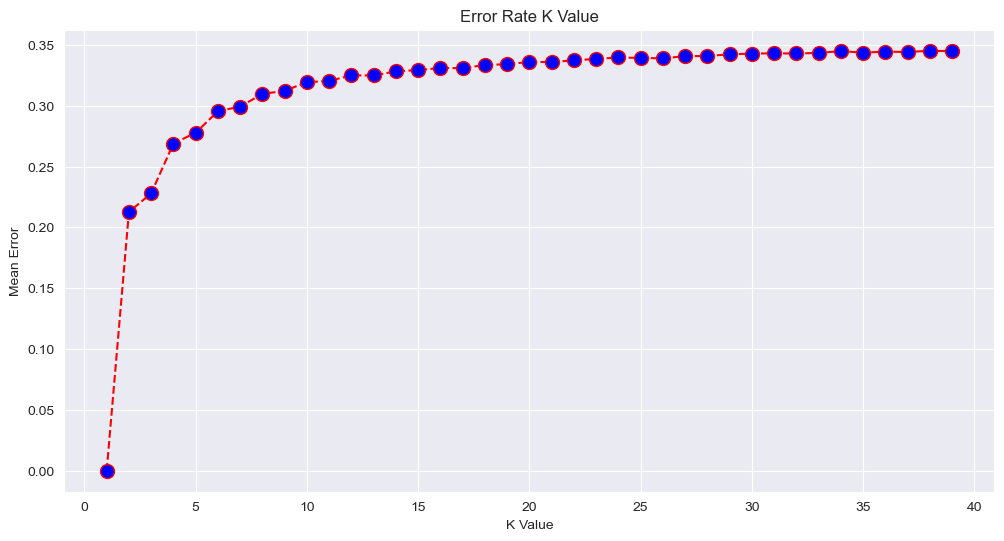

In [120]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40)
         , errors
         , color='RED'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [151]:
# The best value for K = 2
# Adjust and fit the KNN model accordingly
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [152]:
# Train the model
y_pred_train = classifier.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[ 7929     0     0]
 [ 3798 36734     0]
 [  794 10156  9953]]
              precision    recall  f1-score   support

           1       0.63      1.00      0.78      7929
           2       0.78      0.91      0.84     40532
           3       1.00      0.48      0.65     20903

    accuracy                           0.79     69364
   macro avg       0.81      0.79      0.75     69364
weighted avg       0.83      0.79      0.77     69364



In [122]:
# Test the model
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1102  833   47]
 [1724 7376 1034]
 [ 366 3567 1293]]
              precision    recall  f1-score   support

           1       0.35      0.56      0.43      1982
           2       0.63      0.73      0.67     10134
           3       0.54      0.25      0.34      5226

    accuracy                           0.56     17342
   macro avg       0.51      0.51      0.48     17342
weighted avg       0.57      0.56      0.54     17342



Try with 2 features

In [153]:
# Define features and target
X = music_copy[['loudness', 'valence']]
y = music_copy.danceability

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=124, stratify=y)

In [154]:
# Scale the data
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [144]:
## Find the best K value
errors = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)  ##
    knn.fit(X_train, y_train)  ##
    locals()['pred_y_{}'.format(i)] = knn.predict(X_train)  ##
    errors.append(np.mean(locals()['pred_y_{}'.format(i)] != y_train))

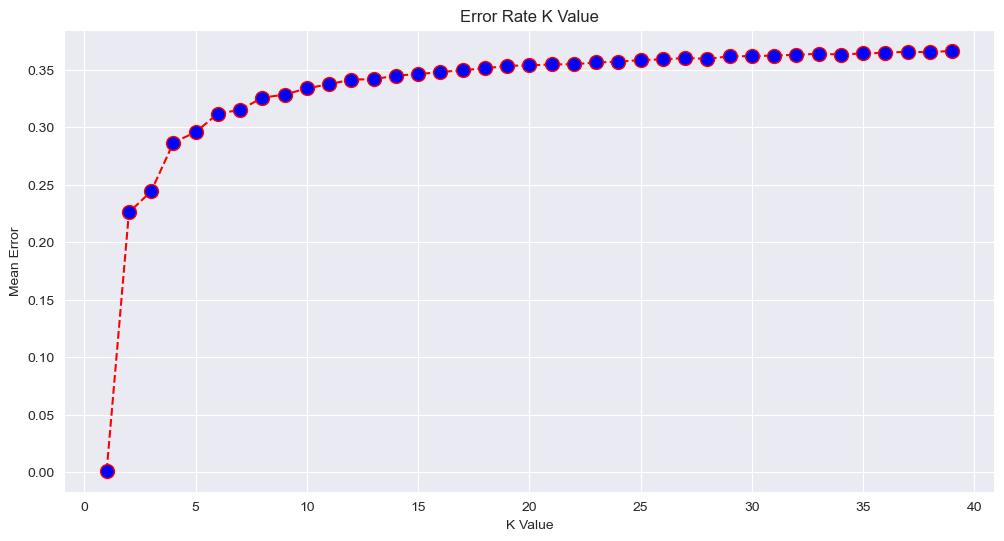

In [145]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40)
         , errors
         , color='RED'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [155]:
# The best value for K = 2
# Adjust and fit the KNN model accordingly
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [156]:
# Train the model
y_pred_train = classifier.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[ 7927     1     1]
 [ 3927 36603     2]
 [ 1048 10688  9167]]
              precision    recall  f1-score   support

           1       0.61      1.00      0.76      7929
           2       0.77      0.90      0.83     40532
           3       1.00      0.44      0.61     20903

    accuracy                           0.77     69364
   macro avg       0.80      0.78      0.73     69364
weighted avg       0.82      0.77      0.76     69364



In [147]:
# Evaluate the model
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1010  916   56]
 [1732 7352 1050]
 [ 502 3640 1084]]
              precision    recall  f1-score   support

           1       0.31      0.51      0.39      1982
           2       0.62      0.73      0.67     10134
           3       0.49      0.21      0.29      5226

    accuracy                           0.54     17342
   macro avg       0.47      0.48      0.45     17342
weighted avg       0.55      0.54      0.52     17342



### <u>Evaluation:</u>

The best performance for a KNN model (without PCA) had an accuracy of 0.57 (weighted) and 0.51 (macro) with 4 features instead of 2.
That said, both models suffered from overfitting with observed reductions in accuracy between training and testing data by around 30 percentage points.

## 3. KNN with PCA

PCA with 2 components

In [157]:
pca = PCA(2)
music_pca_2 = pca.fit_transform(X)
music_pca_2[0:5]

array([[-1.77838638,  0.22282468],
       [ 8.71597273, -0.07424763],
       [ 1.21786338, -0.32913221],
       [ 9.997624  , -0.17982235],
       [ 1.16419278, -0.28289946]])

In [158]:
X = music_pca_2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=124, stratify=y)

In [126]:
errors = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)  ##
    knn.fit(X_train, y_train)  ##
    locals()['pred_y_{}'.format(i)] = knn.predict(X_train)  ##
    errors.append(hamming(locals()['pred_y_{}'.format(i)], y_train))

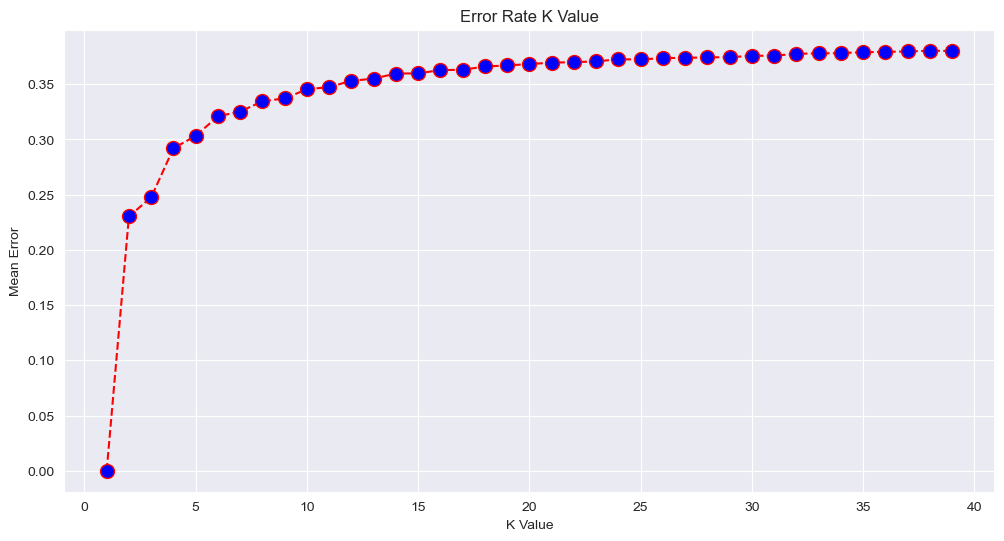

In [127]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40)
         , errors
         , color='red'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [159]:
# The best value for K = 2
# Adjust the KNN model accordingly
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [160]:
# Train model
y_pred_train = classifier.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[ 7929     0     0]
 [ 3978 36553     1]
 [ 1044 10744  9115]]
              precision    recall  f1-score   support

           1       0.61      1.00      0.76      7929
           2       0.77      0.90      0.83     40532
           3       1.00      0.44      0.61     20903

    accuracy                           0.77     69364
   macro avg       0.79      0.78      0.73     69364
weighted avg       0.82      0.77      0.76     69364



In [129]:
# Evaluate model
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 956  961   65]
 [1866 7180 1088]
 [ 454 3738 1034]]
              precision    recall  f1-score   support

           1       0.29      0.48      0.36      1982
           2       0.60      0.71      0.65     10134
           3       0.47      0.20      0.28      5226

    accuracy                           0.53     17342
   macro avg       0.46      0.46      0.43     17342
weighted avg       0.53      0.53      0.51     17342



PCA with 3 components

In [163]:
pca = PCA(3)
music_pca_3 = pca.fit_transform(X)
music_pca_3[0:5]

array([[-1.77205137, -0.08076744,  0.20242596],
       [ 8.72454293, -0.23788358, -0.09987547],
       [ 1.22550367, -0.09301714, -0.3500967 ],
       [10.02581313,  0.74662793, -0.13970858],
       [ 1.16874437, -0.09737541, -0.29911915]])

In [164]:
X = music_pca_3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=124, stratify=y)

In [131]:
errors = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)  ##
    knn.fit(X_train, y_train)  ##
    locals()['pred_y_{}'.format(i)] = knn.predict(X_train)  ##
    errors.append(hamming(locals()['pred_y_{}'.format(i)], y_train))

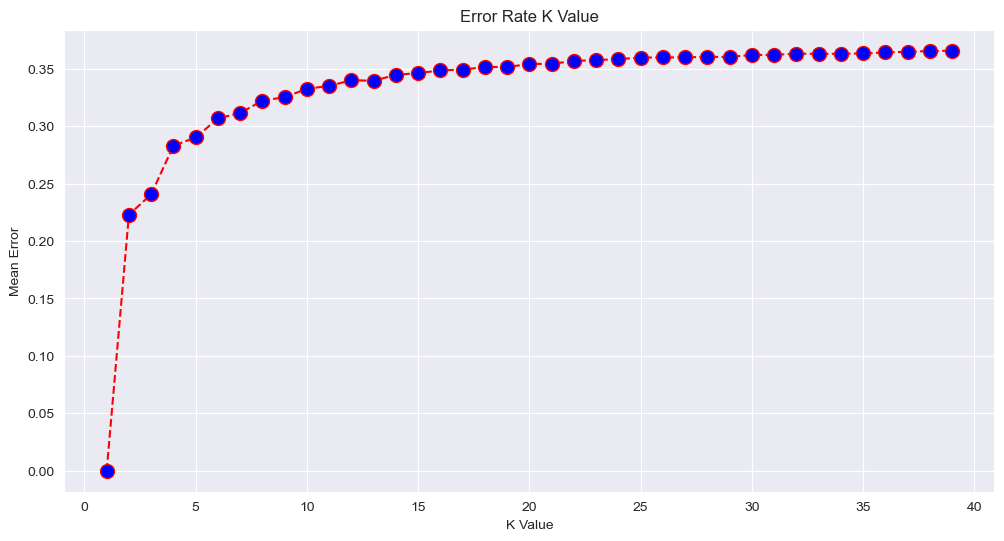

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40)
         , errors
         , color='red'
         , linestyle='dashed'
         , marker='o'
         , markerfacecolor='blue'
         , markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.show()

In [165]:
# The best value for K = 2
# Adjust the KNN model accordingly
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [166]:
# Train model
y_pred_train = classifier.predict(X_train)

print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train))

[[ 7929     0     0]
 [ 3899 36633     0]
 [  911 10647  9345]]
              precision    recall  f1-score   support

           1       0.62      1.00      0.77      7929
           2       0.77      0.90      0.83     40532
           3       1.00      0.45      0.62     20903

    accuracy                           0.78     69364
   macro avg       0.80      0.78      0.74     69364
weighted avg       0.83      0.78      0.76     69364



In [134]:
# Evaluate model
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1043  889   50]
 [1774 7297 1063]
 [ 404 3648 1174]]
              precision    recall  f1-score   support

           1       0.32      0.53      0.40      1982
           2       0.62      0.72      0.66     10134
           3       0.51      0.22      0.31      5226

    accuracy                           0.55     17342
   macro avg       0.48      0.49      0.46     17342
weighted avg       0.55      0.55      0.53     17342



### <u>Evaluation:</u>

The best performance for a KNN model (with PCA) had an accuracy of 0.55 (weighted) and 0.48 (macro) with 3 components instead of 2.
That said, both models suffered from over-fitting with observed reductions in accuracy between training and testing data by around 30 percentage points.

## 4. K-Means with PCA

In [135]:
# Define input variables
X = music_copy[['energy', 'loudness', 'valence', 'time_signature']]


# Scale the data
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
X_scale[0:5]

array([[-0.68292199,  0.33880943,  0.94472436,  0.22440615],
       [-1.83053503, -1.66331895, -0.75924145,  0.22440615],
       [-1.07972379, -0.23153661, -1.31835523,  0.22440615],
       [-2.24445377, -1.90764389, -1.23087484, -1.9864062 ],
       [-0.75294584, -0.22142003, -1.13959096,  0.22440615]])

In [136]:
# Initialise and fit model
pca = PCA(n_components=X_scale.shape[1], svd_solver='auto')
pca.fit_transform(X_scale)

array([[-0.20459762, -0.42554767,  0.9112335 , -0.68610423],
       [ 2.40265207, -0.9783711 ,  0.01461166, -0.11888493],
       [ 1.24390739, -0.37089718, -0.95970345, -0.63397971],
       ...,
       [ 0.57286408, -0.7606166 ,  1.28768475, -0.47683414],
       [ 0.61233944, -0.42040947, -0.03144774, -0.0385109 ],
       [ 0.15786503, -0.55352085,  0.99121664, -0.14530511]])

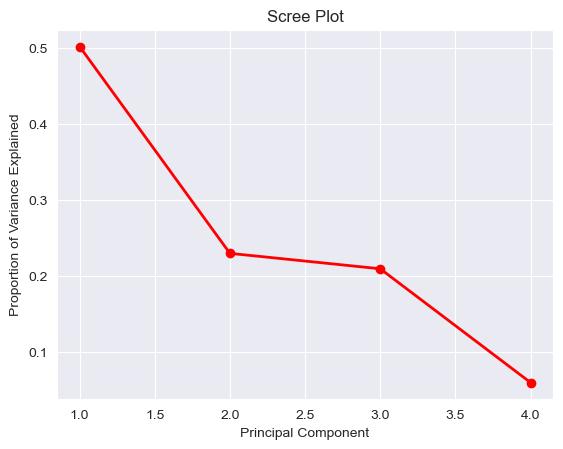

In [137]:
# Plot results
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [138]:
# Proportion of variance explained
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)

# V.s Cumulative proportion
out_sum = np.cumsum(pca.explained_variance_ratio_)
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.50139662 0.22954778 0.20927415 0.05978145]
Cumulative Prop. Variance Explained:  [0.50139662 0.7309444  0.94021855 1.        ]


In [139]:
# Define X_pca on 2 components from X_scale that explain around 73% of the variance within the data
X_pca = PCA(n_components=2, svd_solver='auto').fit_transform(X_scale)

C:\Users\mattw\anaconda3\envs\workspace2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The inertia score for 3 clusters is: 98682.76145150267 

The centers of the clusters are:
 [[-0.8098823   0.02720221]
 [ 2.16729638  2.05931815]
 [ 1.35866396 -0.72255591]]


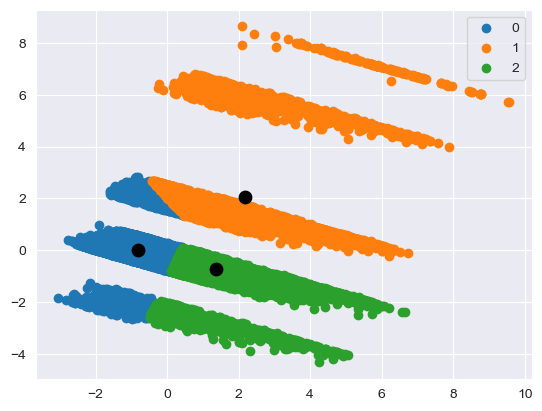

In [140]:
# Set an arbitrary K value before we find the optimum value
kmeans = KMeans(n_clusters=3)
label = kmeans.fit_predict(X_pca)

# Take the unique labels
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

# What the inertia score is and what are the centroids
print(f'The inertia score for {kmeans.n_clusters} clusters is: {kmeans.inertia_}', "\n")
print(f'The centers of the clusters are:\n {centroids}')

# Plot results
for i in u_labels:
    plt.scatter(X_pca[label == i, 0], X_pca[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend()
plt.show()

C:\Users\mattw\anaconda3\envs\workspace2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The inertia score for 4 clusters is: 72046.41098898112 

The centers of the clusters are:
 [[ 0.47475122 -0.42140541]
 [-1.0346033   0.06812643]
 [ 1.48942743  2.33192588]
 [ 2.97415809 -0.84030722]]


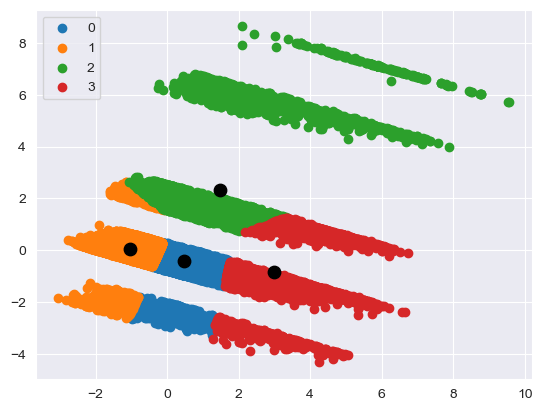

In [141]:
# Set K value to 4
kmeans = KMeans(n_clusters=4)
label = kmeans.fit_predict(X_pca)

# Take the unique labels
u_labels = np.unique(label)
centroids = kmeans.cluster_centers_

# What the inertia score is and what are the centroids
print(f'The inertia score for {kmeans.n_clusters} clusters is: {kmeans.inertia_}', "\n")
print(f'The centers of the clusters are:\n {centroids}')

# Plot results
for i in u_labels:
    plt.scatter(X_pca[label == i, 0], X_pca[label == i, 1], label=i)
plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
plt.legend()
plt.show()

### <u>Evaluation:</u>

With extremely high inertia scores, the K-Means model (with PCA) doesn't accurately group the data into clusters based on the columns selected as inputs.